# **Classifying Clothing Images**

In [33]:
# Import the necessary libraries
import numpy as np
import torch
import matplotlib.pyplot as plt

In [34]:
# Loading the Fashion-MNIST dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
subset_size = int(0.4 * len(trainset))
subset_train_data, _ = random_split(trainset, [subset_size, len(trainset) - subset_size])
trainloader = torch.utils.data.DataLoader(subset_train_data, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

In [35]:
# Examine a sample
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


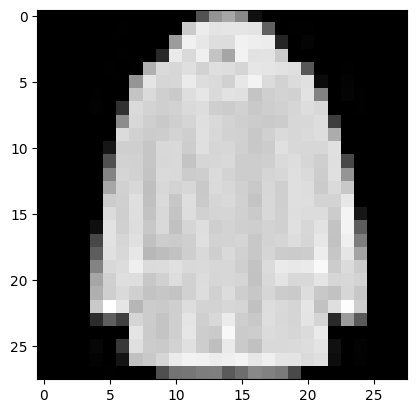

In [36]:
plt.imshow(images[1].numpy().squeeze(), cmap = 'Greys_r')

In [37]:
# Define the network architecture
from torch import nn, optim
import torch.nn.functional as F
from torchsummary import summary
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available! Using GPU for computations.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU for computations.")

class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.7) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(16, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 24, kernel_size=3, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace=True),
            nn.Conv2d(24, 24, kernel_size=3, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            # nn.Dropout(p=dropout),
            nn.Linear(864, 1024),
            nn.ReLU(inplace=True),
            # nn.Dropout(p=dropout),
            nn.Linear(1024, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes),
        )
        self.log_softmax  = nn.LogSoftmax(dim = 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        x = self.log_softmax(x)
        return x

model = AlexNet(10)
# summary(model, (1,28,28))
model.to(device)
# Define the loss
criterion = nn.NLLLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.002)

def label_smoothing(act, pred):
  return -1*(torch.sum(act*pred)/act.shape[0])

CUDA is available! Using GPU for computations.


In [40]:
from tqdm import tqdm
epochs = 30

train_losses, test_losses = [], []

for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    # Flatten Fashion-MNIST images into a 784 long vector
    # images = images.view(images.shape[0], -1)
    images = images.to(device)
    labels = labels.to(device)
    # Training pass
    optimizer.zero_grad()

    output = model(images)
    # with torch.no_grad():
    #   labels_smooth = F.one_hot(labels, 10)
    #   labels_smooth = labels_smooth.float()
    #   labels_smooth = labels_smooth*0.7 + 0.3/10
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0

    # Turn off gradients for validation, saves memory and computation
    with torch.no_grad():
      # Set the model to evaluation mode
      model.eval()

      # Validation pass
      for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        log_ps = model(images)

        test_loss += criterion(log_ps, labels)

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))

    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30.. Training loss: 0.652.. Test loss: 0.435.. Test Accuracy: 0.842
Epoch: 2/30.. Training loss: 0.392.. Test loss: 0.380.. Test Accuracy: 0.862
Epoch: 3/30.. Training loss: 0.343.. Test loss: 0.384.. Test Accuracy: 0.863
Epoch: 4/30.. Training loss: 0.304.. Test loss: 0.415.. Test Accuracy: 0.854
Epoch: 5/30.. Training loss: 0.283.. Test loss: 0.353.. Test Accuracy: 0.869
Epoch: 6/30.. Training loss: 0.259.. Test loss: 0.324.. Test Accuracy: 0.884
Epoch: 7/30.. Training loss: 0.248.. Test loss: 0.338.. Test Accuracy: 0.878
Epoch: 8/30.. Training loss: 0.236.. Test loss: 0.323.. Test Accuracy: 0.892
Epoch: 9/30.. Training loss: 0.217.. Test loss: 0.321.. Test Accuracy: 0.894
Epoch: 10/30.. Training loss: 0.206.. Test loss: 0.345.. Test Accuracy: 0.884
Epoch: 11/30.. Training loss: 0.195.. Test loss: 0.310.. Test Accuracy: 0.899
Epoch: 12/30.. Training loss: 0.185.. Test loss: 0.317.. Test Accuracy: 0.895
Epoch: 13/30.. Training loss: 0.174.. Test loss: 0.297.. Test Accuracy: 0

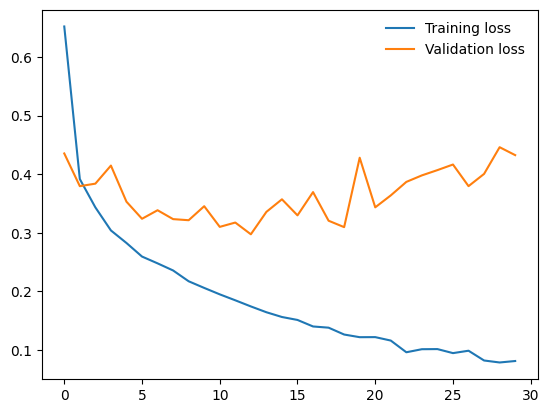

In [41]:
if isinstance(train_losses, torch.Tensor):
    train_losses = train_losses.cpu().numpy()

if isinstance(test_losses, torch.Tensor):
    test_losses = test_losses.cpu().numpy()
train_losses = [loss.cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
test_losses = [loss.cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in test_losses]
plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Validation loss")
plt.legend(frameon = False)